In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
import calendar

## 다운로드 시간 오래 걸림, [2]파일이 미리 준비되어 있으면 패스해도 됨

In [10]:
def get_data():
  all_data = []
  for i in range(0,6):
    year = str(2018+i)
    url1 = 'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/'+year+'/all?type=daily_treasury_yield_curve&field_tdr_date_value='+year+'page&_format=csv'
    data = pd.read_csv(url1)
    all_data.append(data)

  pd_alldata = pd.concat(all_data,ignore_index=True)
  pd_alldata['Date'] = pd.to_datetime(pd_alldata['Date'])
  pd_alldata.index = pd_alldata['Date']
   
  req_cols = ['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr','10 Yr', '20 Yr', '30 Yr']
  final = pd_alldata[req_cols]

  return final

final = get_data()
final.sort_values(by='Date', inplace = True)

tenors = pd.DataFrame({
    "tenor": ['1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr','10 Yr', '20 Yr', '30 Yr'],
    "maturity": [1/12, 1/6, 0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]})

# Extract relevant columns
par_yield = final[tenors["tenor"]]
par_yield.columns
# Create a boolean mask indicating rows with any missing values
mask = par_yield.isna().all(axis=1)
par_yield[mask]

par_yield = par_yield.dropna(how='all', axis=0)
if par_yield.duplicated(keep='last').sum() != 0:
    par_yield = par_yield.drop_duplicates(keep='last')

par_yield.to_csv('./par_yield.csv',index = True)
# 업데이트를 가져와서 디비를 갱신하는 프로세스 필요

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1495 entries, 2018-01-02 to 2023-12-21
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1 Mo    1495 non-null   float64
 1   2 Mo    1297 non-null   float64
 2   3 Mo    1495 non-null   float64
 3   6 Mo    1495 non-null   float64
 4   1 Yr    1495 non-null   float64
 5   2 Yr    1495 non-null   float64
 6   3 Yr    1495 non-null   float64
 7   5 Yr    1495 non-null   float64
 8   7 Yr    1495 non-null   float64
 9   10 Yr   1495 non-null   float64
 10  20 Yr   1495 non-null   float64
 11  30 Yr   1495 non-null   float64
dtypes: float64(12)
memory usage: 151.8 KB


In [2]:
# Load data
url2 = './par_yield.csv'  # daily return timeseries
par_yield = pd.read_csv(url2, index_col='Date', parse_dates=True)

tenors = pd.DataFrame({
    "tenor": ['1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr','10 Yr', '20 Yr', '30 Yr'],
    "maturity": [1/12, 1/6, 0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]})

# Extract relevant columns
par_yield = par_yield[tenors["tenor"]]

yield_curve = par_yield[tenors["tenor"]].dropna(how ='any', axis = 0)
yield_curve

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,
2018-10-16,2.19,2.22,2.30,2.46,2.66,2.87,2.95,3.02,3.10,3.16,3.26,3.32
2018-10-17,2.20,2.23,2.31,2.47,2.66,2.89,2.97,3.04,3.13,3.19,3.29,3.35
2018-10-18,2.19,2.23,2.32,2.47,2.67,2.87,2.95,3.03,3.11,3.17,3.28,3.36
2018-10-19,2.19,2.23,2.31,2.48,2.67,2.92,2.99,3.05,3.14,3.20,3.31,3.38
2018-10-22,2.18,2.25,2.34,2.49,2.68,2.92,2.99,3.05,3.13,3.20,3.31,3.38
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-15,5.54,5.54,5.44,5.33,4.95,4.44,4.13,3.91,3.94,3.91,4.19,4.00
2023-12-18,5.52,5.52,5.46,5.36,4.95,4.43,4.15,3.94,3.97,3.95,4.23,4.05
2023-12-19,5.51,5.51,5.43,5.35,4.93,4.41,4.15,3.94,3.96,3.93,4.23,4.03


## 채권가격을 산출하는 함수

In [3]:
def bond_price(trading_date, yld_rate, maturity_date, cpn_rate, face_value, cpn_freq):
    # 날짜 형식 지정
    # date_format = '%Y-%m-%d'
 
    # # 만기일과 거래일 설정
    # trading_date = dt.datetime.strptime(trading_date, date_format)
    # maturity_date = dt.datetime.strptime(maturity_date, date_format)
    coupon = face_value * cpn_rate / cpn_freq
 
   
    # 현금흐름 스케줄 생성
    coupon_count = 0
    coupon_date = maturity_date

    while coupon_date > trading_date:
        # 쿠폰 금액 설정
        coupon_count += 1
        next_cpn_date = coupon_date
        # 6개월씩 전으로 이동
        next_month = coupon_date.month - 6
        next_year = coupon_date.year

        # 월이 음수가 되면 연도를 조정하고 월을 업데이트
        while next_month < 1:
            next_year -= 1
            next_month += 12

        # 다음 월의 마지막 날을 구함
        next_month_last_day = calendar.monthrange(next_year, next_month)[1]
        # print(coupon_count, coupon_date)
        # 보정된 날짜 설정 (캘린더에 없는 날짜인 경우에만 조정)
        adjusted_date = dt.datetime(year=next_year, month=next_month, day=min(maturity_date.day, next_month_last_day))

        # 캘린더에 없는 날짜인 경우에만 조정 후 종료
        if adjusted_date.day != coupon_date.day:
            coupon_date = adjusted_date
        coupon_date = dt.datetime(year=next_year, month=next_month, day=min(maturity_date.day, next_month_last_day))        

    if (next_cpn_date - coupon_date).days == 0:
        rd = 0  # Avoid division by zero
    else:
        rd = (next_cpn_date - trading_date).days / max(1, (next_cpn_date - coupon_date).days)
        

    # 각 기간에 따른 할인율 계산
    discount_factors = [1 / (1 + yld_rate / cpn_freq)**(i + rd) for i in range(coupon_count)]

    # 총 가격 계산
    bond_price = round(sum([coupon * discount_factors[i] for i in range(coupon_count)]) + face_value * discount_factors[-1], 4)
    # print(tenor, trading_date.strftime('%Y-%m-%d'), yld_rate, maturity_date.strftime('%Y-%m-%d'), cpn_rate, price, daily_return)
       
    return bond_price

## par_yield UST Curve에서 채권가격함수를 써서 Tenor별 리턴값을 생성

In [4]:
# # Initialize an empty DataFrame to store results
face_value = 10000
cpn_freq =2
maturity_in_days_dict = {tenor: 365 * tenors.loc[tenors["tenor"] == tenor, "maturity"].values[0] for tenor in yield_curve.columns}

total_return = pd.DataFrame(index=yield_curve.index, columns=yield_curve.columns)


# Loop through each row (date)
for i in range(1, len(yield_curve)):
    trading_date = yield_curve.index[i]
    previous_date = yield_curve.index[i - 1]

    # Loop through each column (tenor)
    for tenor in yield_curve.columns:
        maturity_in_days = maturity_in_days_dict[tenor]
        maturity_date = previous_date + timedelta(days=int(maturity_in_days))

        # Get the previous and current business day's yields
        cpn_rate = round(yield_curve[tenor].loc[previous_date] / 100, 6)  # Convert yield to a decimal
        yld_rate = round(yield_curve[tenor].loc[trading_date] / 100, 6)

        # Calculate price changes for the current tenor and date
        if maturity_in_days <= 360:
            # Calculate T-bill price
            maturity_in_day0 = (previous_date - trading_date).days + timedelta(days=int(maturity_in_days)).days
            tbill_price = face_value * (1- yld_rate * int(maturity_in_day0)/360)
            tbill_pric0 = face_value * (1- cpn_rate * int(maturity_in_days)/360)
            daily_return = tbill_price / tbill_pric0 - 1
        else:
            price = bond_price(trading_date, yld_rate, maturity_date, cpn_rate, face_value, cpn_freq)
            daily_return = price / face_value - 1
            
        total_return.at[trading_date, tenor] = daily_return
        
total_return.applymap(lambda x: '{:.2%}'.format(x))
mask = total_return.isna().all(axis=1)
total_return[mask]

total_return = total_return.dropna(how='all', axis=0)

if total_return.duplicated(keep='last').sum() != 0:
    total_return = total_return.drop_duplicates(keep='last')

total_return.to_csv('./daily_return.csv', index = True)
# 업데이트를 가져와서 디비를 갱신하는 프로세스 필요

# Par_yield 스팟커브의 평균과 분산, 그리고 공분산과 상관계수 등의 특성을 살펴봄

In [5]:

desc_yield_curve = yield_curve.describe()
desc_yield_curve.loc['count'] = desc_yield_curve.loc['count'].astype(int).astype(str)
desc_yield_curve.iloc[1:] = desc_yield_curve.iloc[1:].applymap('{:.2f}'.format)
desc_yield_curve = desc_yield_curve.loc[['count', 'mean','std']]

desc_yield_curve

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
count,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297
mean,1.86,1.93,1.97,2.07,2.09,2.06,2.05,2.10,2.22,2.30,2.67,2.70
std,1.91,1.94,1.96,1.97,1.90,1.70,1.57,1.39,1.27,1.16,1.09,0.95


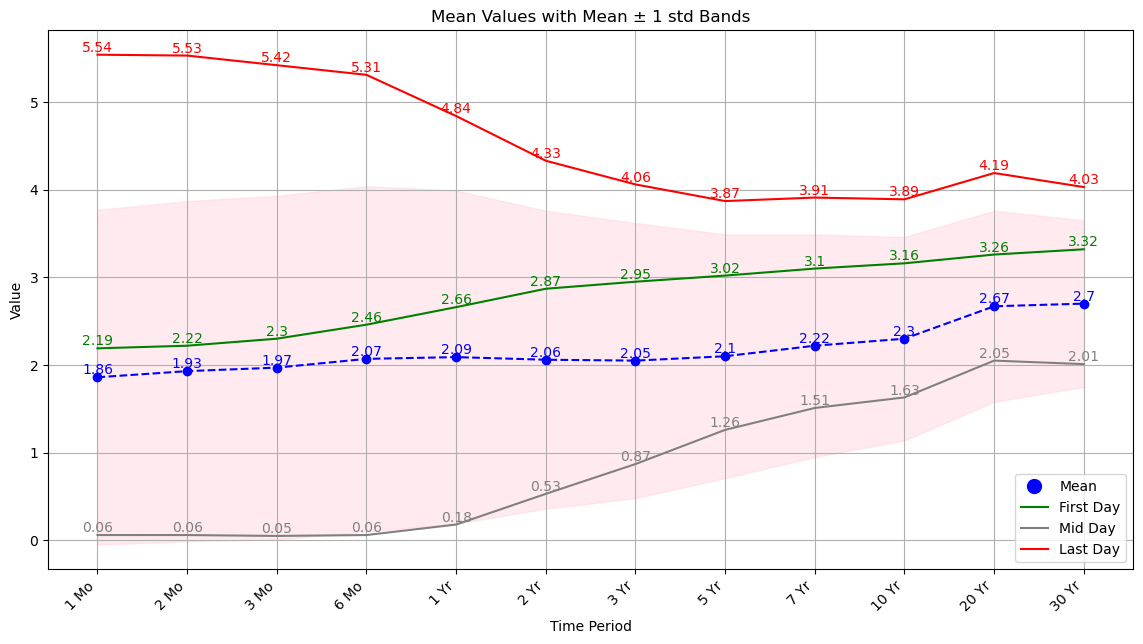

In [8]:
from matplotlib.lines import Line2D

# Assuming desc_yield_curve is your DataFrame
mean_values = pd.to_numeric(desc_yield_curve.loc['mean'])
std_values = pd.to_numeric(desc_yield_curve.loc['std'])
                           # .str.rstrip('%')) 
upper_band = mean_values + std_values
lower_band = mean_values - std_values

firstday = yield_curve.iloc[0]
midday =  yield_curve.iloc[770]
lastday = yield_curve.iloc[-1]

firstday_label = yield_curve.index[0].strftime('%Y-%m-%d')
midday_label = yield_curve.index[770].strftime('%Y-%m-%d')
lastday_label = yield_curve.index[-1].strftime('%Y-%m-%d')

# Plotting
plt.figure(figsize=(14, 7))

# Plot mean values
plt.plot(desc_yield_curve.columns.values, mean_values, label='Mean', marker='o', linestyle='dashed', color='blue')

# Convert lower_band and upper_band to numeric
lower_band_numeric = pd.to_numeric(lower_band, errors='coerce')
upper_band_numeric = pd.to_numeric(upper_band, errors='coerce')

# Plot mean + 1 std and mean - 1 std bands
plt.fill_between(desc_yield_curve.columns.values, lower_band_numeric, upper_band_numeric, color='pink', alpha=0.3, label='Mean ± 1 std')

# Plot individual days
plt.plot(desc_yield_curve.columns.values, firstday, label=firstday_label, linestyle='solid', color='green')
plt.plot(desc_yield_curve.columns.values, midday, label=midday_label, linestyle='solid', color='gray')  # Change color to gray
plt.plot(desc_yield_curve.columns.values, lastday, label=lastday_label, linestyle='solid', color='red')

# Define data and corresponding colors
data_values = [mean_values, firstday, midday, lastday]
data_colors = ['blue', 'green', 'gray', 'red']  # Corrected color for midday
data_labels = ['Mean', 'First Day', 'Mid Day', 'Last Day']

# Iterate through data and add data labels
for values, color, label in zip(data_values, data_colors, data_labels):
    for i, txt in enumerate(values):
        plt.text(desc_yield_curve.columns.values[i], values[i], f'{np.round(txt, 2)}', ha='center', va='bottom', color=color)

# Create custom legend handles
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=12, label='Mean'),
    Line2D([0], [0], linestyle='solid', color='green', label='First Day'),
    Line2D([0], [0], linestyle='solid', color='gray', label='Mid Day'),
    Line2D([0], [0], linestyle='solid', color='red', label='Last Day')
]

# Additional plot customization
plt.title('Mean Values with Mean ± 1 std Bands')
plt.xlabel('Time Period')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.legend(handles=legend_handles, loc='lower right')  # Use custom legend handles
plt.grid(True)

# Show the plot
plt.show()

# 일드커브는 18년10월 녹색커브에서 20년 Covid 이후 21년11월까지 회색커브로 있다가
# 기간중 평균커브는 파랑색점선커브이며 테너별 1표준편차 범위의 밴드 위쪽에
# 연준의 연이은 빅스텝으로 23년12월 빨강색커브에 있음

In [9]:
cov_yield_curve = yield_curve.cov().applymap('{:.2f}'.format)
print('covariance')
cov_yield_curve.style.background_gradient(cmap='YlGn', axis=1)

covariance


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
1 Mo,3.66,3.70,3.72,3.70,3.51,3.03,2.73,2.37,2.16,1.97,1.82,1.63
2 Mo,3.70,3.77,3.80,3.79,3.61,3.13,2.83,2.45,2.23,2.04,1.88,1.68
3 Mo,3.72,3.80,3.84,3.84,3.66,3.19,2.89,2.50,2.28,2.08,1.92,1.71
6 Mo,3.70,3.79,3.84,3.88,3.73,3.28,2.98,2.58,2.35,2.14,1.98,1.75
1 Yr,3.51,3.61,3.66,3.73,3.61,3.21,2.94,2.55,2.32,2.11,1.95,1.71
2 Yr,3.03,3.13,3.19,3.28,3.21,2.90,2.67,2.34,2.12,1.92,1.77,1.55
3 Yr,2.73,2.83,2.89,2.98,2.94,2.67,2.48,2.17,1.98,1.79,1.65,1.44
5 Yr,2.37,2.45,2.50,2.58,2.55,2.34,2.17,1.92,1.76,1.60,1.48,1.29
7 Yr,2.16,2.23,2.28,2.35,2.32,2.12,1.98,1.76,1.61,1.47,1.37,1.19
10 Yr,1.97,2.04,2.08,2.14,2.11,1.92,1.79,1.60,1.47,1.35,1.26,1.10


In [10]:
corr_yield_curve = yield_curve.corr()
print('correlation')
corr_yield_curve.style.background_gradient(cmap='YlGn', axis=None).format("{:.0%}")

correlation


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
1 Mo,100%,100%,99%,98%,96%,93%,91%,89%,89%,89%,88%,90%
2 Mo,100%,100%,100%,99%,98%,95%,93%,91%,91%,90%,89%,91%
3 Mo,99%,100%,100%,100%,98%,96%,94%,92%,92%,91%,90%,92%
6 Mo,98%,99%,100%,100%,100%,98%,96%,95%,94%,93%,92%,93%
1 Yr,96%,98%,98%,100%,100%,99%,98%,97%,96%,95%,94%,95%
2 Yr,93%,95%,96%,98%,99%,100%,100%,99%,98%,97%,96%,96%
3 Yr,91%,93%,94%,96%,98%,100%,100%,100%,99%,98%,97%,96%
5 Yr,89%,91%,92%,95%,97%,99%,100%,100%,100%,99%,98%,98%
7 Yr,89%,91%,92%,94%,96%,98%,99%,100%,100%,100%,99%,99%
10 Yr,89%,90%,91%,93%,95%,97%,98%,99%,100%,100%,100%,99%


# par_yield_daily_change에 따른 리턴값에 대해 평균과 분산, 그리고 공분산과 상관계수 등의 특성을 살펴봄

In [11]:
url2 = './daily_return.csv'  # daily return timeseries
daily_return = pd.read_csv(url2, index_col='Date', parse_dates=True)

tenors = pd.DataFrame({
    "tenor": ['1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr','10 Yr', '20 Yr', '30 Yr'],
    "maturity": [1/12, 1/6, 0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]})

# Extract relevant columns
daily_return = daily_return[tenors["tenor"]]*100

daily_return = daily_return[tenors["tenor"]].dropna(how ='any', axis = 0)
daily_return.applymap(lambda x: '{:.3f}'.format(x))

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,
2018-10-17,0.005,0.005,0.004,0.002,0.007,-0.023,-0.041,-0.076,-0.162,-0.220,-0.384,-0.483
2018-10-18,0.007,0.006,0.004,0.007,-0.003,0.054,0.073,0.063,0.150,0.205,0.200,-0.106
2018-10-19,0.006,0.006,0.009,0.002,0.007,-0.081,-0.098,-0.075,-0.162,-0.220,-0.382,-0.293
2018-10-22,0.019,0.015,0.012,0.016,0.012,0.032,0.033,0.033,0.105,0.052,0.072,0.101
2018-10-23,0.004,0.010,0.009,0.012,0.017,0.074,0.130,0.201,0.213,0.290,0.345,0.271
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-15,0.015,0.016,0.013,0.005,-0.021,-0.109,-0.089,-0.013,-0.029,0.124,0.337,0.619
2023-12-18,0.048,0.050,0.041,0.030,0.053,0.067,-0.011,-0.082,-0.128,-0.264,-0.445,-0.744
2023-12-19,0.016,0.017,0.023,0.020,0.046,0.062,0.022,0.032,0.093,0.207,0.069,0.445


In [12]:
desc_daily_return = daily_return.describe()
desc_daily_return.loc['count'] = desc_daily_return.loc['count'].astype(int).astype(str)
desc_daily_return.iloc[1:] = desc_daily_return.iloc[1:].applymap('{:.3f}'.format)
desc_daily_return = desc_daily_return.loc[['count', 'mean','std']]
print('description')
desc_daily_return.style.background_gradient(axis=0,  cmap='viridis')

description


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
count,1296,1296,1296,1296,1296,1296,1296,1296,1296,1296,1296,1296
mean,0.007,0.007,0.007,0.007,0.010,0.011,0.011,0.014,0.017,0.023,0.039,0.062
std,0.012,0.012,0.012,0.020,0.050,0.118,0.179,0.292,0.396,0.523,0.883,1.173


# ** 30년물 5년동안 누적리턴이 80%, 1m 단기물은 10%
## 어떻게 이렇게 높은 누적리턴이? 30년물 금리는 18년10월에 3.32%에서 23년12월 4.02%인데 어떻게 이런 수익이 발생할 수 있었나?
## 주된 요인은 30년물을 매영업일 리밸런싱하여 캐리한 것에서 발생, 리밸런싱 주기는 통상 3/6개월 정도로 하는 것이 현실적임

In [13]:
def calculate_cumulative_return(daily_return, tenors, initial_value=100):
    daily_return = daily_return[tenors["tenor"]] / 100

    cumulative_return = daily_return.copy()
    cumulative_return.iloc[:, :] = None

    for tenor in cumulative_return.columns:
        cumulative_return[tenor] = (1 + daily_return[tenor]).cumprod() * initial_value

    return cumulative_return

# Example usage:
cumulative_return = calculate_cumulative_return(daily_return, tenors)


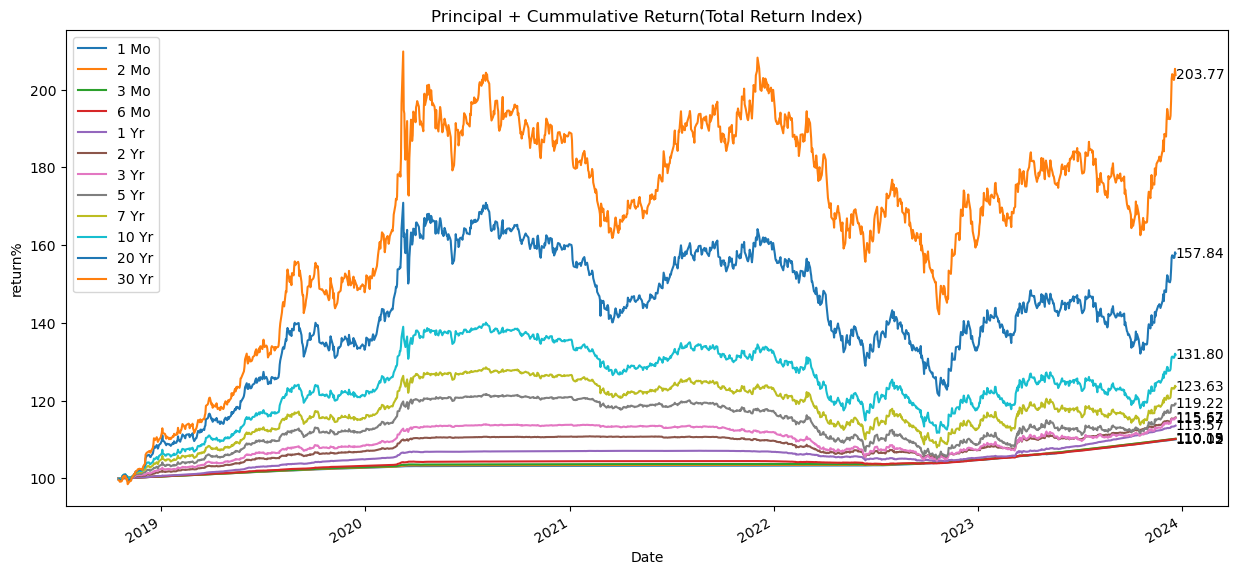

In [15]:
cumulative_return.plot(figsize=(15,7))
plt.ylabel("return%")
plt.title("Principal + Cummulative Return(Total Return Index)")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# Add labels for the final cumulative return value on the last date
for tenor in cumulative_return.columns:
    final_return = cumulative_return[tenor].iloc[-1]
    plt.text(cumulative_return.index[-1], final_return, f'{final_return:.2f}', ha='left', va='center')

plt.show()


In [16]:
daily_return = daily_return[tenors["tenor"]] # 반복 실행시 *100이 *10000이 됨
cov_daily_return = daily_return.cov().applymap('{:.3%}'.format)
print('covariance(%)')
cov_daily_return 


covariance(%)


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
1 Mo,0.013%,0.012%,0.009%,0.009%,0.014%,0.014%,0.013%,0.011%,0.008%,0.009%,0.004%,-0.003%
2 Mo,0.012%,0.013%,0.011%,0.012%,0.023%,0.032%,0.037%,0.046%,0.047%,0.054%,0.064%,0.068%
3 Mo,0.009%,0.011%,0.015%,0.017%,0.031%,0.051%,0.065%,0.091%,0.105%,0.127%,0.180%,0.214%
6 Mo,0.009%,0.012%,0.017%,0.040%,0.081%,0.155%,0.212%,0.305%,0.367%,0.435%,0.585%,0.695%
1 Yr,0.014%,0.023%,0.031%,0.081%,0.246%,0.496%,0.699%,1.020%,1.246%,1.459%,1.864%,2.207%
2 Yr,0.014%,0.032%,0.051%,0.155%,0.496%,1.398%,2.023%,3.101%,3.883%,4.629%,6.154%,7.337%
3 Yr,0.013%,0.037%,0.065%,0.212%,0.699%,2.023%,3.196%,4.994%,6.419%,7.818%,10.779%,13.019%
5 Yr,0.011%,0.046%,0.091%,0.305%,1.020%,3.101%,4.994%,8.522%,11.258%,14.133%,20.540%,25.274%
7 Yr,0.008%,0.047%,0.105%,0.367%,1.246%,3.883%,6.419%,11.258%,15.678%,20.176%,30.719%,38.481%
10 Yr,0.009%,0.054%,0.127%,0.435%,1.459%,4.629%,7.818%,14.133%,20.176%,27.390%,43.535%,55.818%


In [17]:
corr_daily_return = daily_return.corr()
print('correlation')
corr_daily_return.style.background_gradient(cmap='YlGn', axis=None).format("{:.0%}")

correlation


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
1 Mo,100%,86%,65%,38%,24%,10%,6%,3%,2%,1%,0%,-0%
2 Mo,86%,100%,77%,53%,39%,23%,18%,14%,10%,9%,6%,5%
3 Mo,65%,77%,100%,72%,52%,35%,30%,26%,22%,20%,17%,15%
6 Mo,38%,53%,72%,100%,81%,65%,59%,52%,46%,42%,33%,30%
1 Yr,24%,39%,52%,81%,100%,85%,79%,70%,63%,56%,43%,38%
2 Yr,10%,23%,35%,65%,85%,100%,96%,90%,83%,75%,59%,53%
3 Yr,6%,18%,30%,59%,79%,96%,100%,96%,91%,84%,68%,62%
5 Yr,3%,14%,26%,52%,70%,90%,96%,100%,97%,93%,80%,74%
7 Yr,2%,10%,22%,46%,63%,83%,91%,97%,100%,97%,88%,83%
10 Yr,1%,9%,20%,42%,56%,75%,84%,93%,97%,100%,94%,91%


# 데일리리턴에 대해 PCA분석을 3성분만으로 수행 

In [18]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn-v0_8")
sns.set_style('darkgrid')
sns.set_context("talk")

df = daily_return[tenors["tenor"]]
df.dropna(inplace=True)

instruments = df.columns


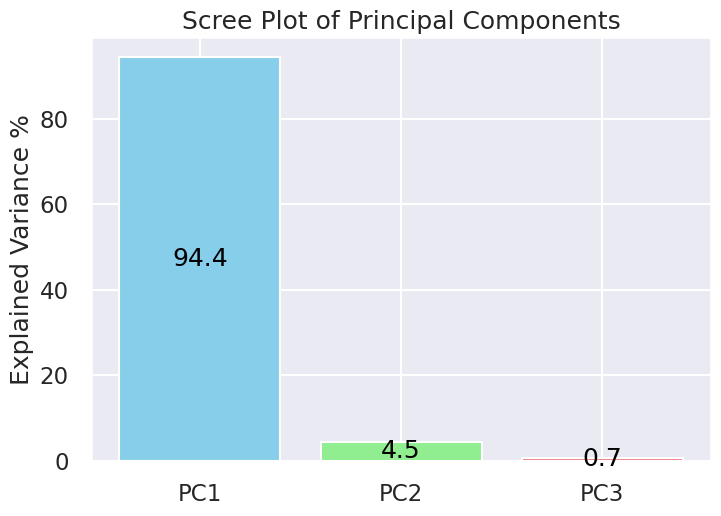

In [19]:
scaler = StandardScaler(with_mean=True, with_std=False)
normalized_data = scaler.fit_transform(df)

n_comps = 3
pca = PCA(n_components = n_comps)
principal_components = pca.fit_transform(normalized_data)

per_var = np.round(pca.explained_variance_ratio_ * 100 , decimals=1)

# Assuming 'per_var' is a list containing the explained variance for each PC
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

# Create a bar plot
fig, ax = plt.subplots()
bars = plt.bar(labels, per_var, color=['skyblue', 'lightgreen', 'lightcoral'])

# Add text labels to each bar
for bar, var_ratio in zip(bars, per_var):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{var_ratio:.1f}', 
            ha='center', va='center', color='black')

plt.ylabel('Explained Variance %')
plt.title('Scree Plot of Principal Components')
plt.show()


In [20]:
topPorfolios = pd.DataFrame(pca.components_[:n_comps-1],columns=instruments)
eigenPortfolios = topPorfolios.div(topPorfolios.sum(1),axis=0)
eigenPortfolios.index = ['Duration_Effect', 'Covexity_Effect']
eigenPortfolios

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Duration_Effect,0.000014,0.000229,0.000627,0.002061,0.006648,0.021669,0.037642,0.071004,0.105438,0.148842,0.260566,0.345260
Covexity_Effect,0.001222,0.002953,0.004216,0.014765,0.052316,0.145717,0.212606,0.298853,0.315482,0.259656,-0.018813,-0.288974


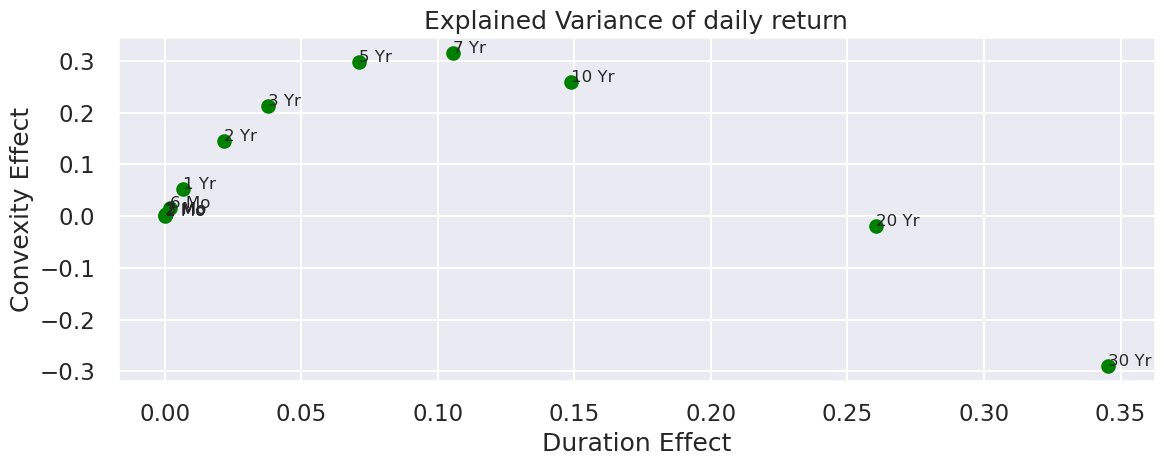

In [21]:
plt.figure(figsize=(12, 5))  # Set the overall figure size

# PC1 vs. PC2 subplot
# plt.subplot(1, 2, 1)
plt.scatter(eigenPortfolios.loc['Duration_Effect'], eigenPortfolios.loc['Covexity_Effect'], color='green')
plt.title('Explained Variance of daily return')
for i, label in enumerate(tenors["tenor"]):
    plt.annotate(label, (eigenPortfolios.loc['Duration_Effect'][i], eigenPortfolios.loc['Covexity_Effect'][i]), size=12)
plt.xlabel('Duration Effect')
plt.ylabel('Convexity Effect')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

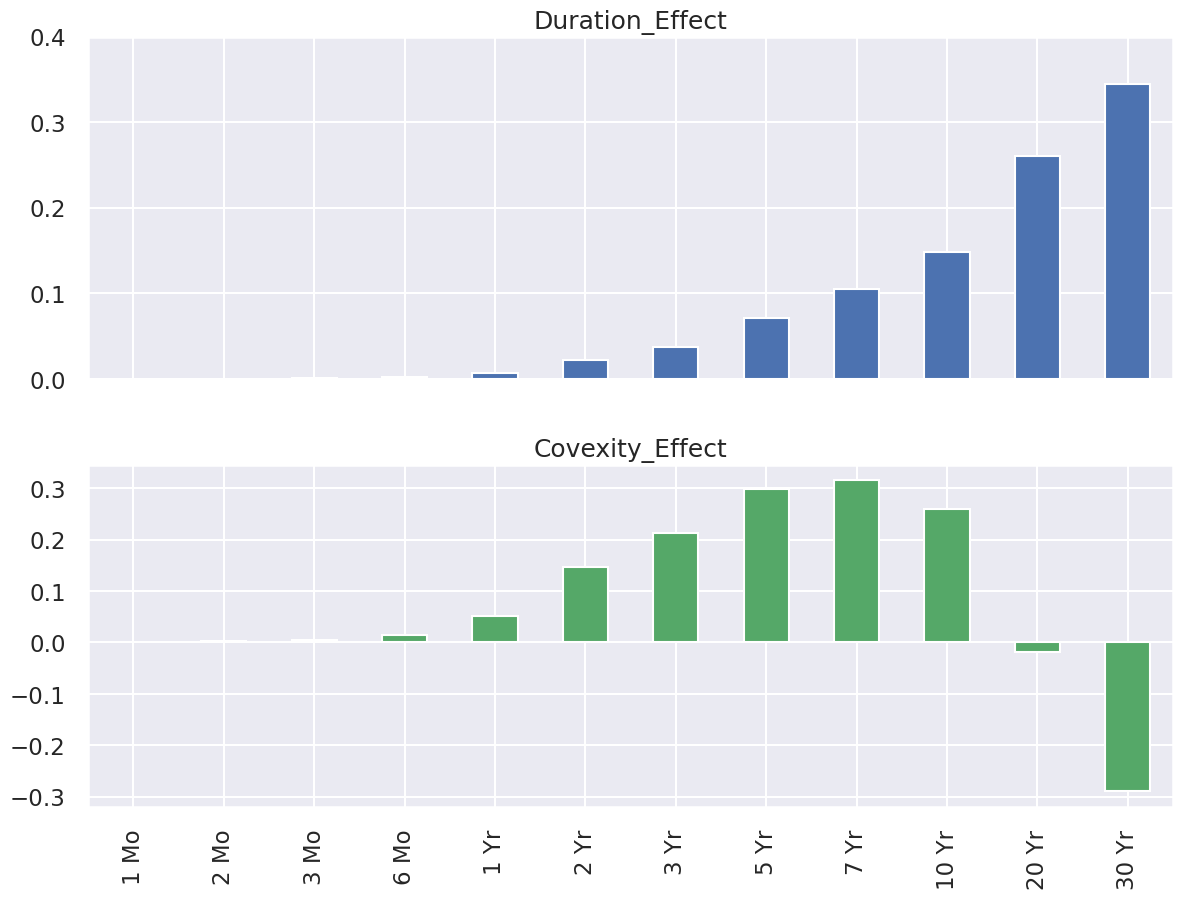

In [22]:
axs = eigenPortfolios.T.plot.bar(subplots=True,figsize=(14,10),legend=False)
plt.subplots_adjust(hspace=0.25)
axs[0].set_ylim(0,.4);

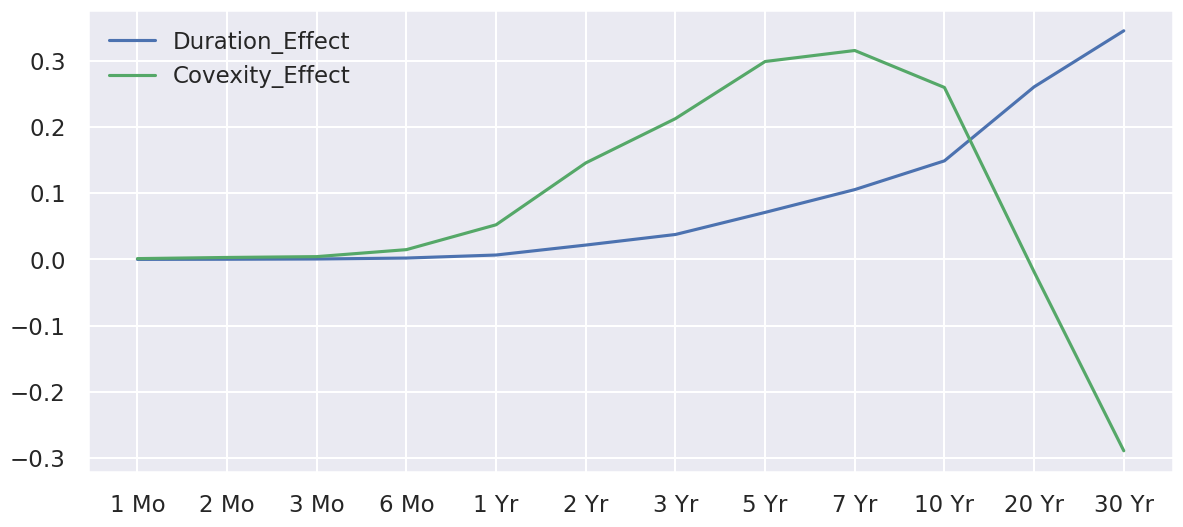

In [23]:
axs = eigenPortfolios.T.plot(subplots=False,figsize=(14,6),legend=True);
axs.set_xticks(range(len(instruments)))
axs.set_xticklabels(instruments);

## 복제된 리턴누적값 추이와 누적오차의 추이를 살펴봄

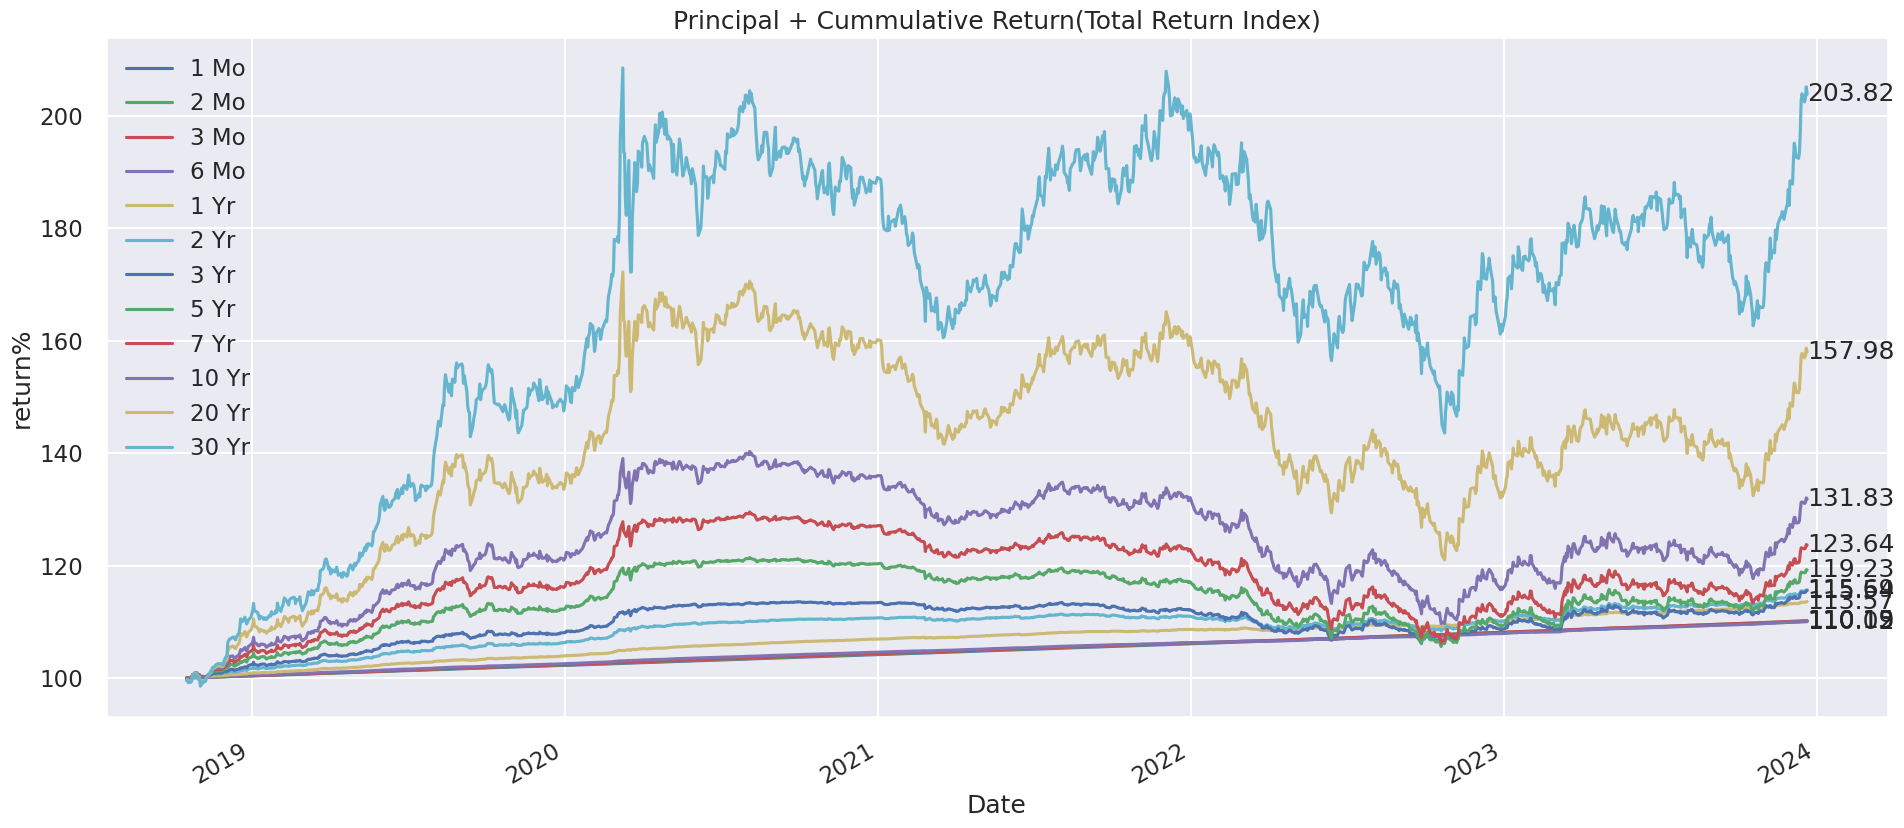

In [24]:
# Reconstruct the yields using the first three principal components
reconstructed_data = np.dot(principal_components[:, :2], pca.components_[:2, :]) + scaler.mean_

# Convert the reconstructed data back to a DataFrame
reconstructed_df = pd.DataFrame(data=reconstructed_data, columns=df.columns, index=df.index)

reconstructed_total_return = calculate_cumulative_return(reconstructed_df, tenors)

reconstructed_total_return.plot(figsize=(23,10))
plt.ylabel("return%")
plt.title("Principal + Cummulative Return(Total Return Index)")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# Add labels for the final cumulative return value on the last date
for tenor in reconstructed_total_return.columns:
    final_return = reconstructed_total_return[tenor].iloc[-1]
    plt.text(reconstructed_total_return.index[-1], final_return, f'{final_return:.2f}', ha='left', va='center')

plt.show()


## 3가지 성분만으로 재구성한 복제된 데일리 리턴값의 누적추이는 원본 리턴값의 패턴과 99% 일치 ?

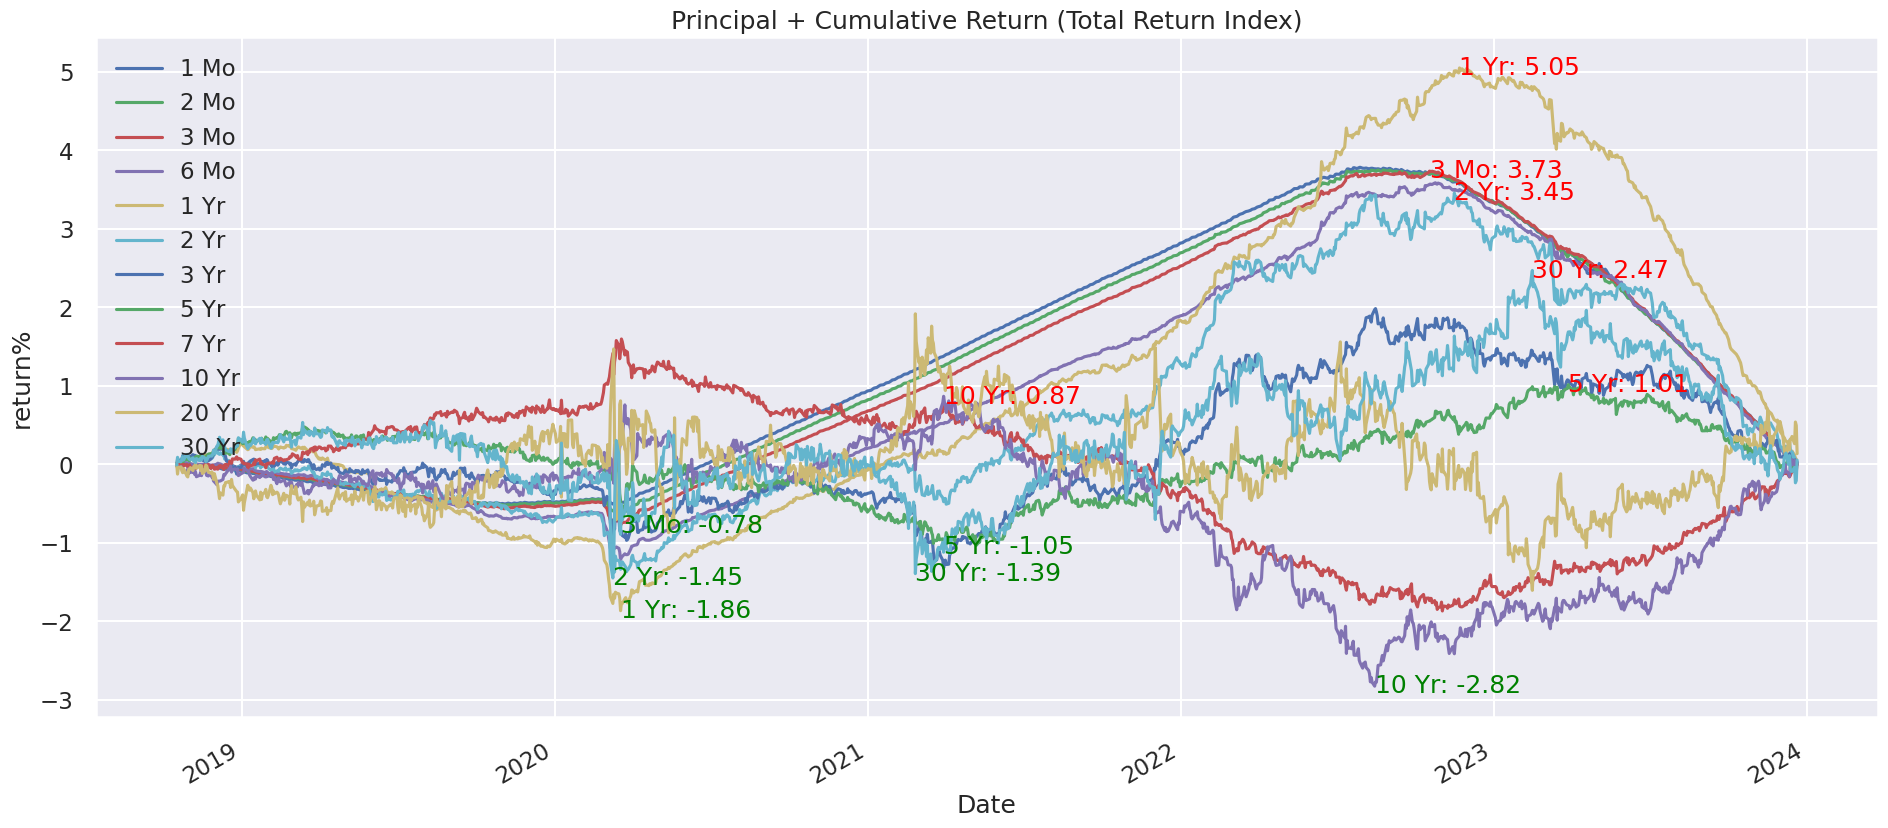

In [25]:
# Create an error DataFrame
tr_error = reconstructed_total_return - cumulative_return

# Plot the cumulative return
tr_error.plot(figsize=(23, 10))
plt.ylabel("return%")
plt.title("Principal + Cumulative Return (Total Return Index)")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# Add labels for the maximum and minimum cumulative return values on their respective dates
for tenor in ["3 Mo", "1 Yr", "2 Yr", "5 Yr", "10 Yr", "30 Yr"]:
    max_idx = tr_error[tenor].idxmax()
    min_idx = tr_error[tenor].idxmin()

    max_value = tr_error.at[max_idx, tenor]
    min_value = tr_error.at[min_idx, tenor]

    # Add label for maximum value
    plt.text(max_idx, max_value, f'{tenor}: {max_value:.2f}', ha='left', va='center', color='red')

    # Add label for minimum value
    plt.text(min_idx, min_value, f'{tenor}: {min_value:.2f}', ha='left', va='center', color='green')

plt.show()

# 20년3월 이후로 Covid로 제로금리로 가져가고 22년 3월부터 빅스텝을 밟아서 올리는 동안 
# 3m, 1y이하의 단기물의 실제 누적리턴은 복제된 모델의 리턴값을 3.5%~5%까지 상회
# 반면 동기간에 10년물 이상은 실제 누적리턴은 복제된 모델의 리턴값을 -2.82% 까지 하회

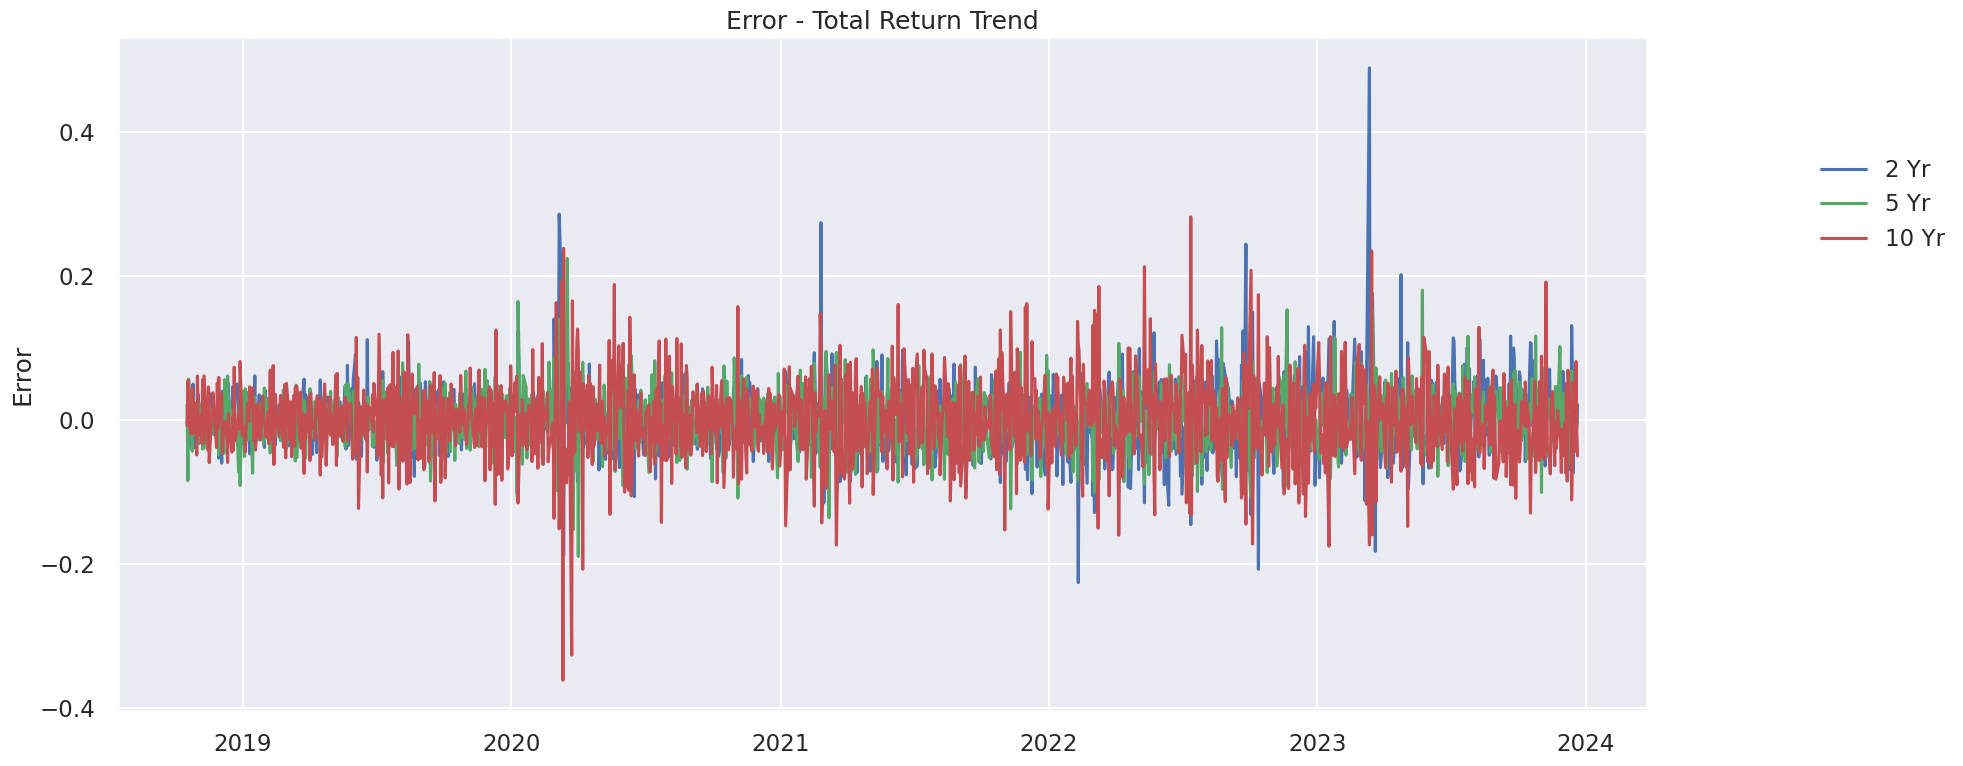

In [26]:
# Create an error DataFrame
df_error = df - reconstructed_df

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))

# Plot the raw values for selected columns in the second subplot
for column in ["2 Yr", "5 Yr", "10 Yr"]:
    ax2.plot(df_error[column], label=column)

# Adding labels and legend for the second subplot
ax2.set_title('Error - Total Return Trend')
ax2.set_ylabel('Error')
ax2.legend(bbox_to_anchor=(1.1, 0.85), loc=2)

# Display the plot
plt.tight_layout()
plt.show()

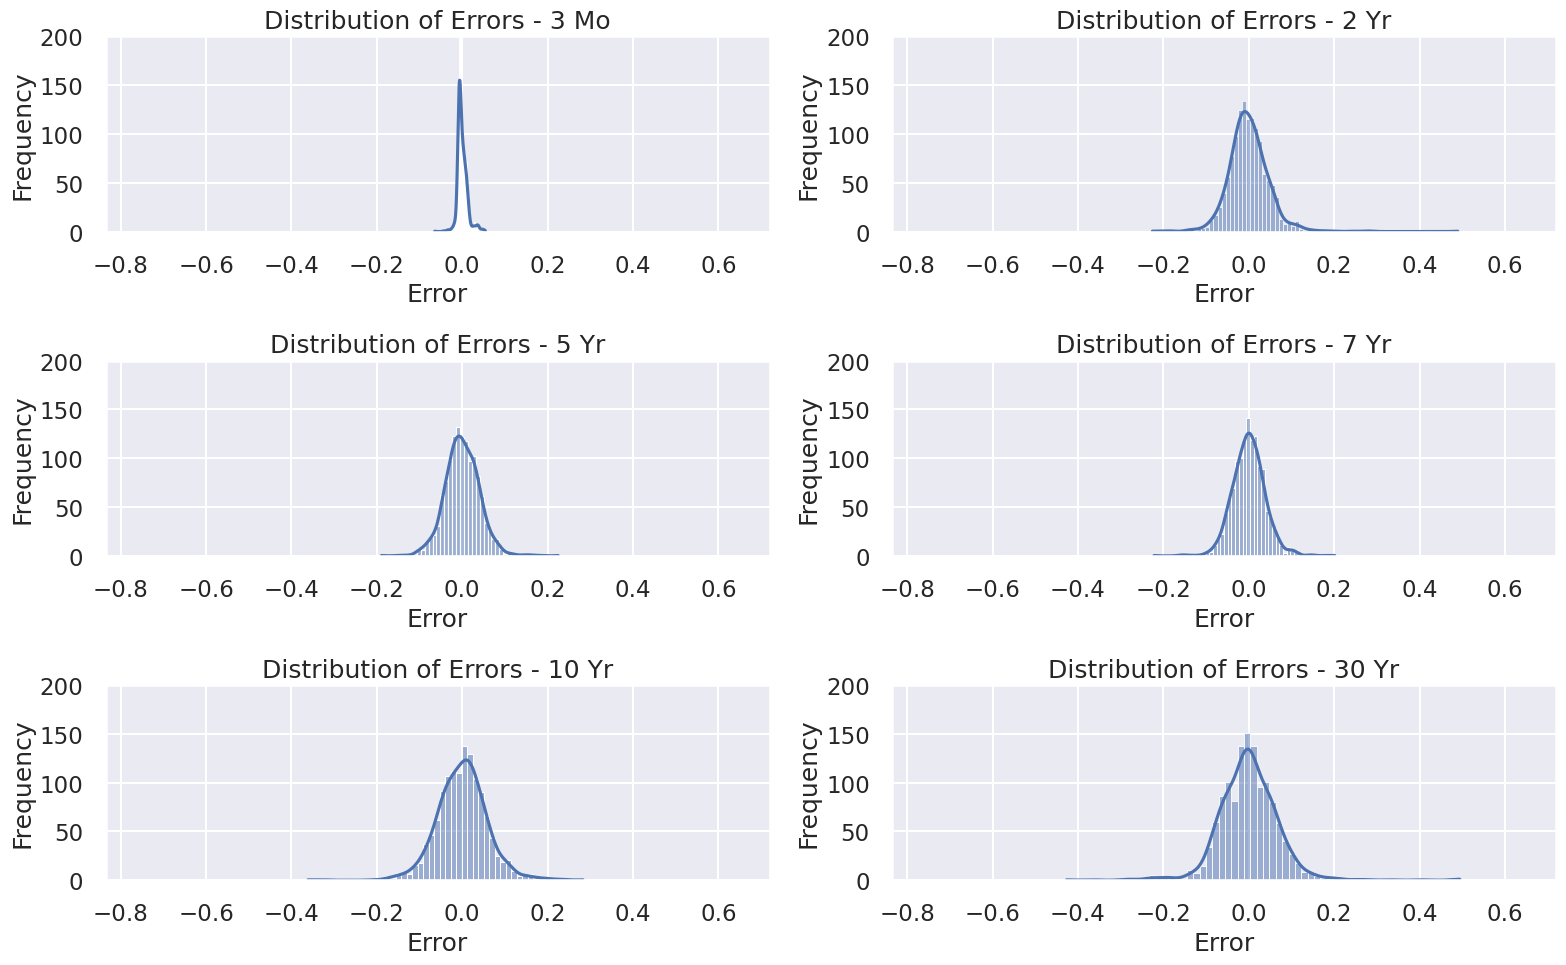

In [27]:
# Set up the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Calculate the common X-axis limits
x_min = df_error.min().min()
x_max = df_error.max().max()
y_min = 0  # Start Y-axis from 0
y_max = 200 # df_error.apply(lambda x: len(x)).max()  # Use the maximum count as Y-axis limit

# Plot the distribution of errors for each column
for i, column in enumerate(["3 Mo", "2 Yr", "5 Yr", "7 Yr", "10 Yr", "30 Yr"]):
    sns.histplot(df_error[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of Errors - {column}')
    axes[i].set_xlabel('Error')
    axes[i].set_ylabel('Frequency')
    
    # Set common X-axis limits
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

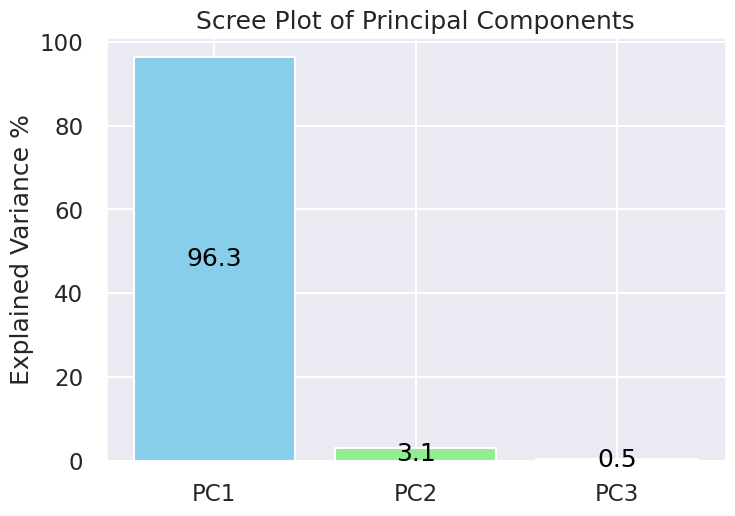

In [28]:

df = yield_curve[tenors["tenor"]]
df.dropna(inplace=True)

instruments = df.columns

scaler = StandardScaler(with_mean=True, with_std=False)
normalized_data = scaler.fit_transform(df)

n_comps = 3
pca = PCA(n_components = n_comps)
principal_components = pca.fit_transform(normalized_data)

per_var = np.round(pca.explained_variance_ratio_ * 100 , decimals=1)

# Assuming 'per_var' is a list containing the explained variance for each PC
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

# Create a bar plot
fig, ax = plt.subplots()
bars = plt.bar(labels, per_var, color=['skyblue', 'lightgreen', 'lightcoral'])

# Add text labels to each bar
for bar, var_ratio in zip(bars, per_var):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{var_ratio:.1f}', 
            ha='center', va='center', color='black')

plt.ylabel('Explained Variance %')
plt.title('Scree Plot of Principal Components')
plt.show()



In [29]:
topPorfolios = pd.DataFrame(pca.components_[:n_comps],columns=instruments)
eigenPortfolios = topPorfolios.div(topPorfolios.sum(1),axis=0)
eigenPortfolios.index = ['Level', 'Slope', 'Curvarture']
eigenPortfolios

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Level,0.100890,0.103511,0.104992,0.106361,0.102869,0.091466,0.083663,0.073070,0.066657,0.060723,0.056202,0.049596
Slope,-0.671101,-0.566973,-0.489412,-0.260417,0.000919,0.315287,0.451998,0.514330,0.502294,0.456085,0.442713,0.304277
Curvarture,0.559180,0.252920,0.089161,-0.353853,-0.646812,-0.801973,-0.686853,-0.132715,0.290632,0.638027,0.866714,0.925571


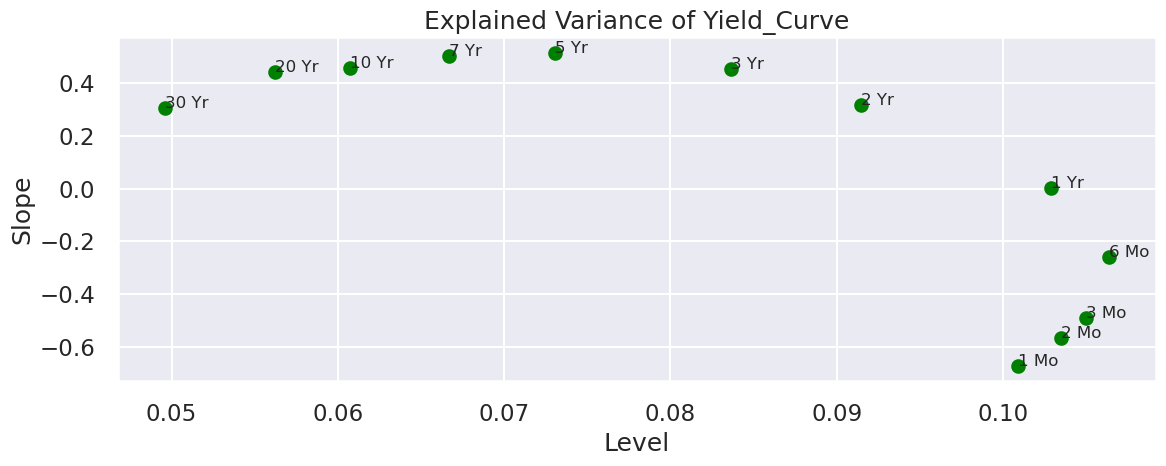

In [30]:
plt.figure(figsize=(12, 5))  # Set the overall figure size

# PC1 vs. PC2 subplot
# plt.subplot(1, 3, 1)
plt.scatter(eigenPortfolios.loc['Level'], eigenPortfolios.loc['Slope'], color='green')
plt.title('Explained Variance of Yield_Curve')
for i, label in enumerate(tenors["tenor"]):
    plt.annotate(label, (eigenPortfolios.loc['Level'][i], eigenPortfolios.loc['Slope'][i]), size=12)
plt.xlabel('Level')
plt.ylabel('Slope')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

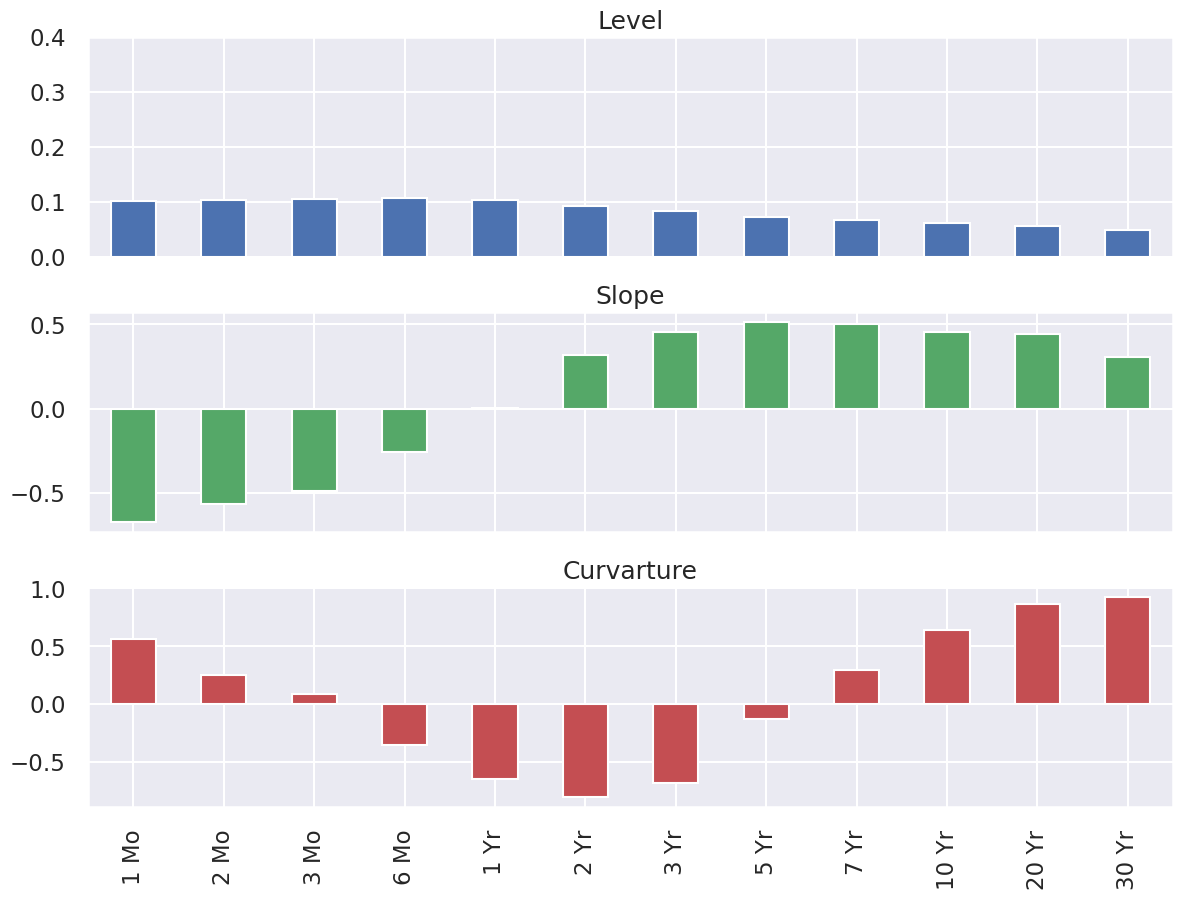

In [31]:
axs = eigenPortfolios.T.plot.bar(subplots=True,figsize=(14,10),legend=False)
plt.subplots_adjust(hspace=0.25)
axs[0].set_ylim(0,.4);

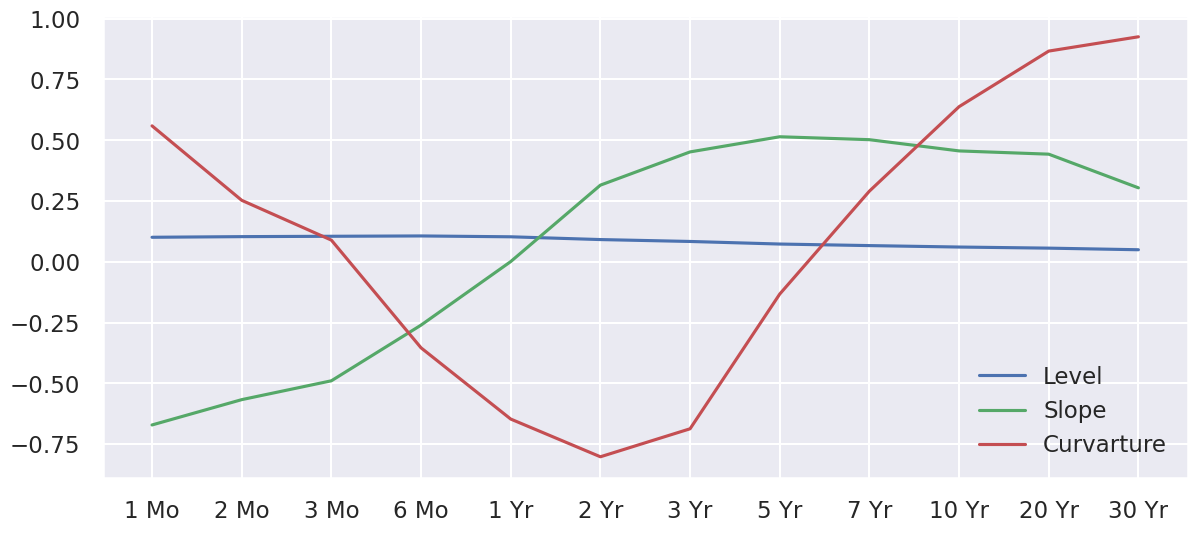

In [32]:
axs = eigenPortfolios.T.plot(subplots=False,figsize=(14,6),legend=True);
axs.set_xticks(range(len(instruments)))
axs.set_xticklabels(instruments);

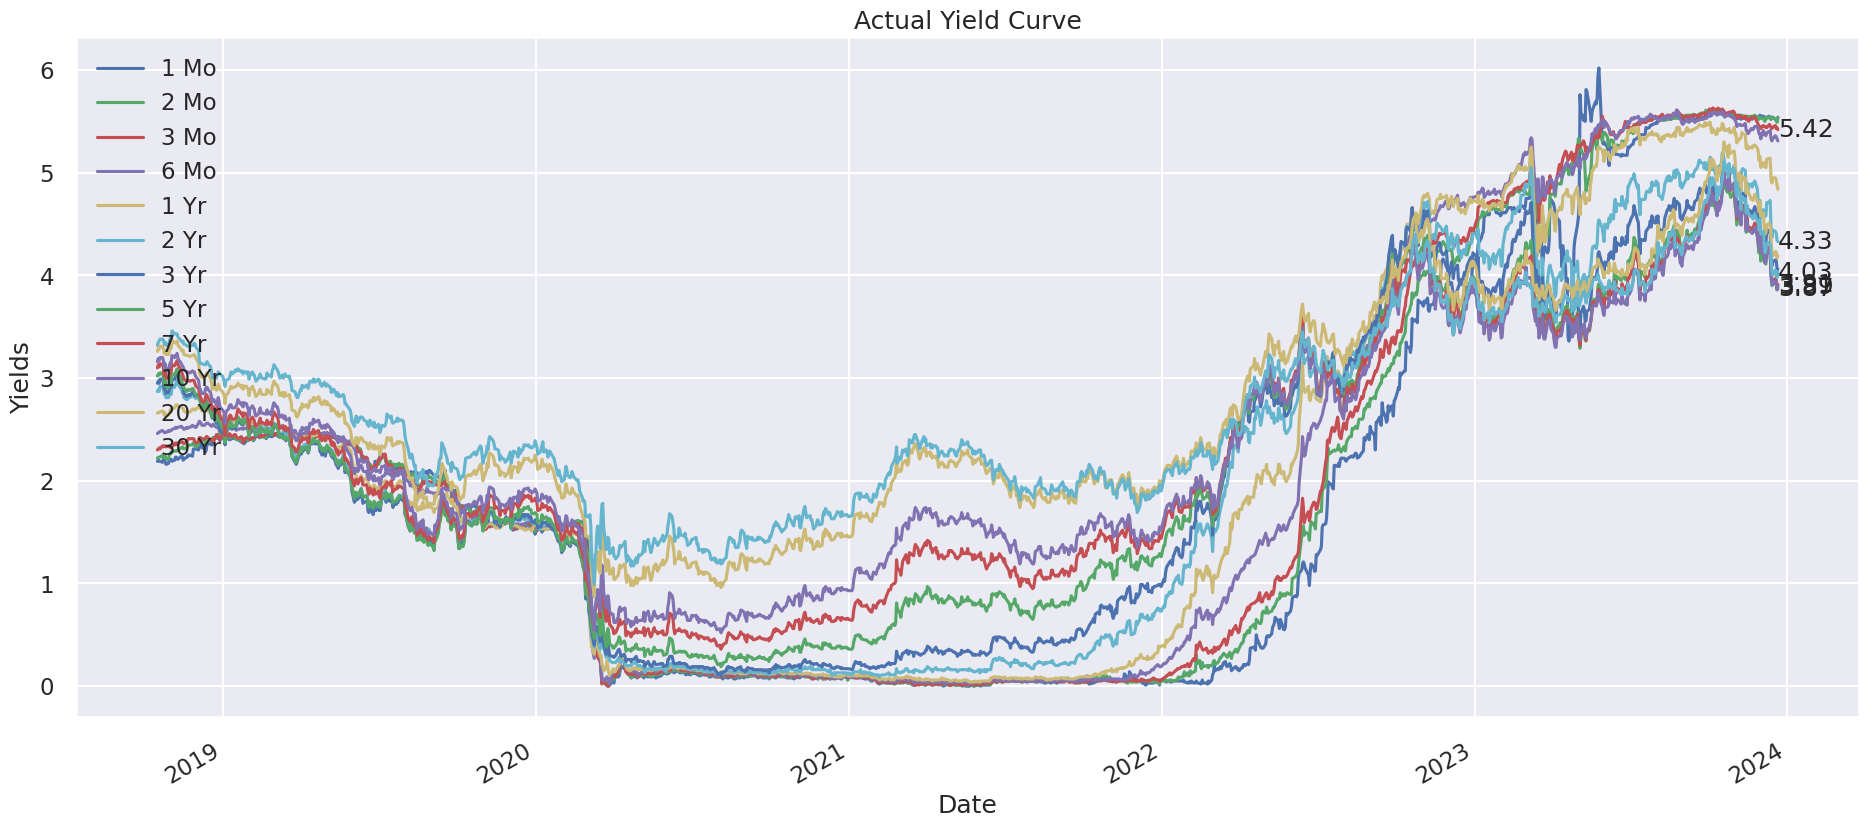

In [33]:
yield_curve.plot(figsize=(23,10))
plt.ylabel("Yields")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')
plt.title("Actual Yield Curve")
# Add labels for the final cumulative return value on the last date
for tenor in ["3 Mo", "2 Yr", "5 Yr", "7 Yr", "10 Yr", "30 Yr"]:
    final_return = yield_curve[tenor].iloc[-1]
    plt.text(yield_curve.index[-1], final_return, f'{final_return:.2f}', ha='left', va='center')

plt.show()

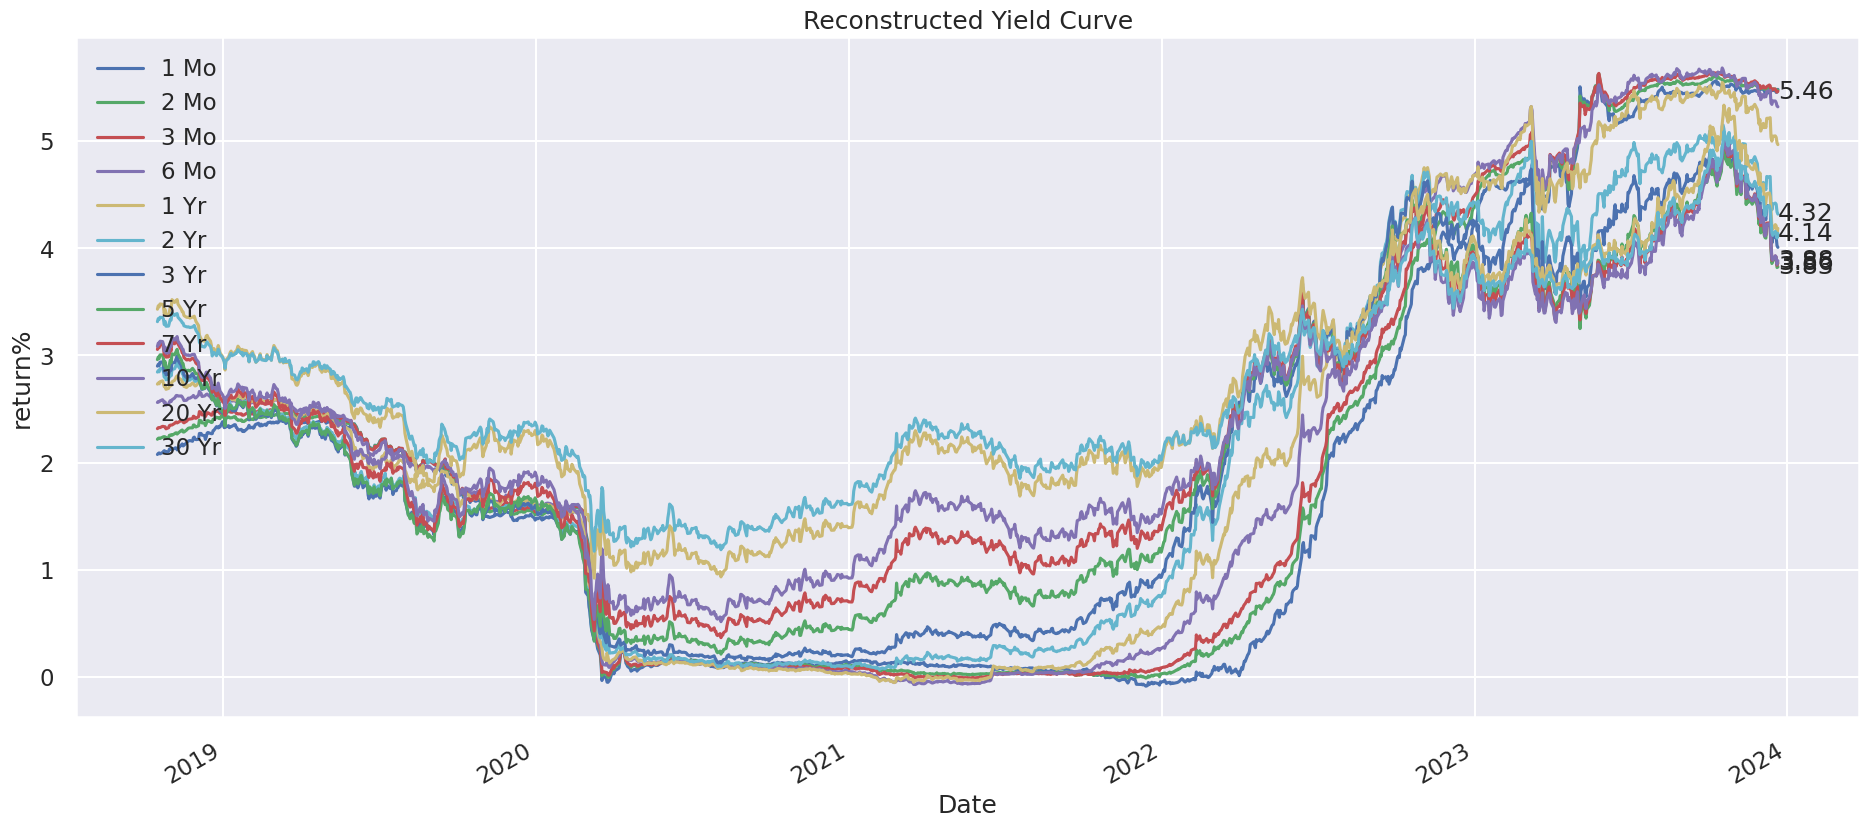

In [34]:
# Reconstruct the yields using the first three principal components
reconstructed_data = np.dot(principal_components, pca.components_) + scaler.mean_

# Convert the reconstructed data back to a DataFrame
reconstructed_df = pd.DataFrame(data=reconstructed_data, columns=df.columns, index=df.index)

reconstructed_df.plot(figsize=(23,10))
plt.ylabel("return%")
plt.title("Reconstructed Yield Curve")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# Add labels for the final cumulative return value on the last date
for tenor in ["3 Mo", "2 Yr", "5 Yr", "7 Yr", "10 Yr", "30 Yr"]:
    final_return = reconstructed_df[tenor].iloc[-1]
    plt.text(reconstructed_df.index[-1], final_return, f'{final_return:.2f}', ha='left', va='center')

plt.show()


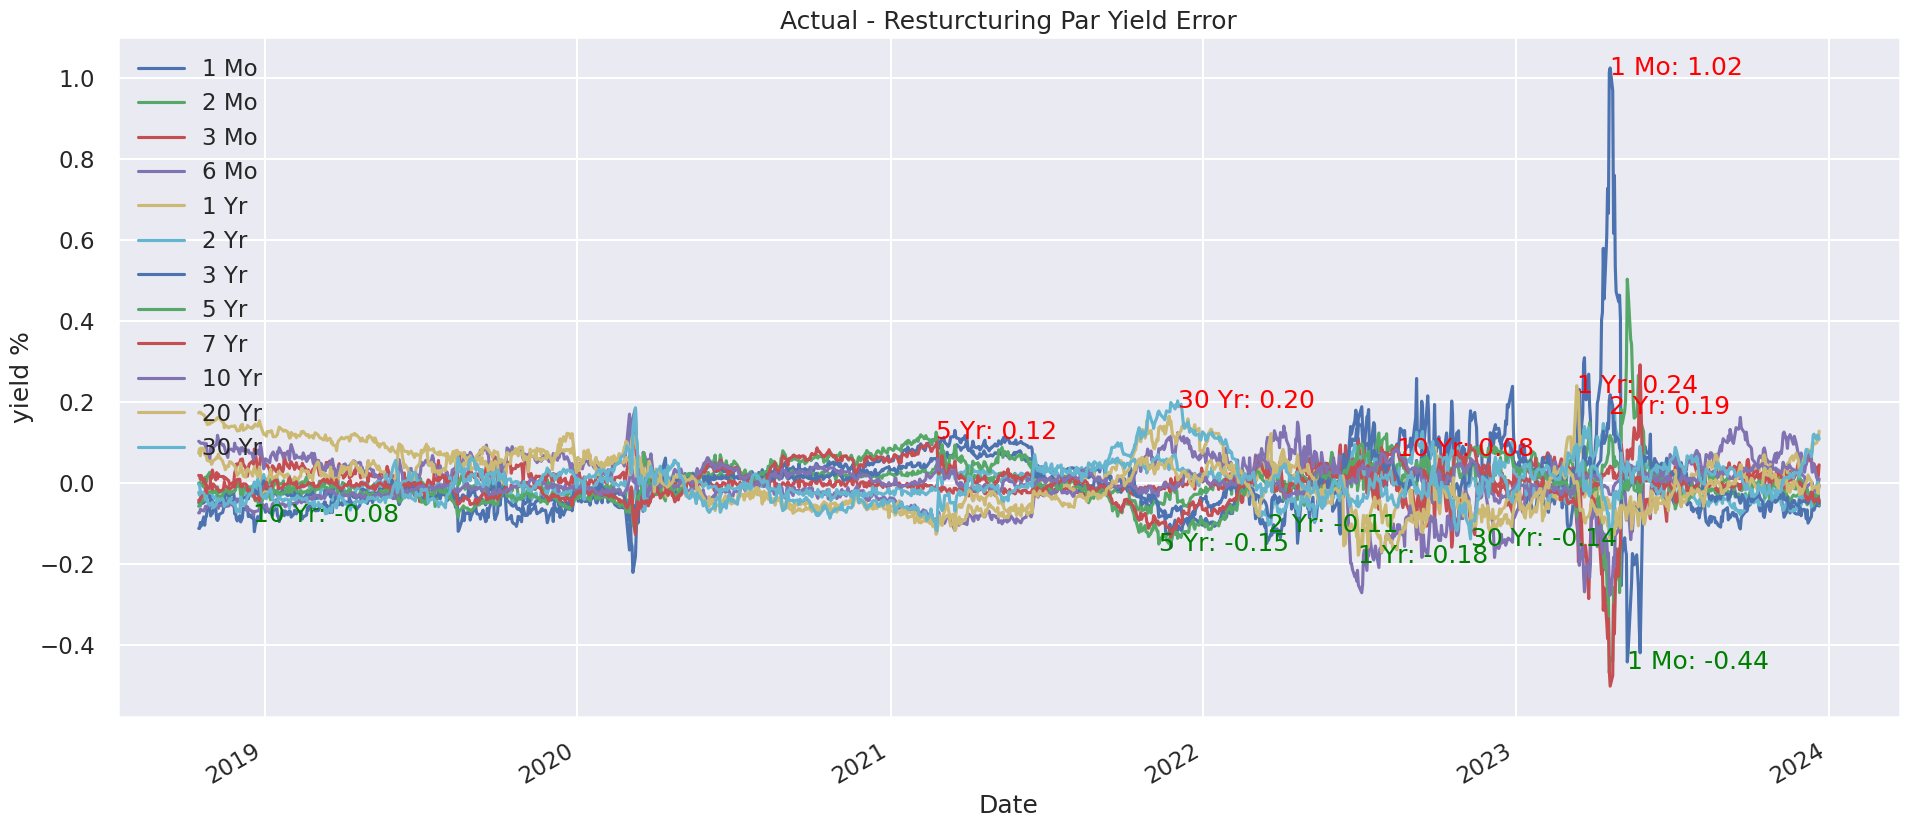

In [35]:
# Create an error DataFrame
df_error = reconstructed_df - df

# Plot the cumulative return
df_error.plot(figsize=(23, 10))
plt.ylabel("yield %")
plt.title("Actual - Resturcturing Par Yield Error")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# Add labels for the maximum and minimum cumulative return values on their respective dates
for tenor in ["1 Mo", "1 Yr", "2 Yr", "5 Yr", "10 Yr", "30 Yr"]:
    max_idx = df_error[tenor].idxmax()
    min_idx = df_error[tenor].idxmin()

    max_value = df_error.at[max_idx, tenor]
    min_value = df_error.at[min_idx, tenor]

    # Add label for maximum value
    plt.text(max_idx, max_value, f'{tenor}: {max_value:.2f}', ha='left', va='center', color='red')

    # Add label for minimum value
    plt.text(min_idx, min_value, f'{tenor}: {min_value:.2f}', ha='left', va='center', color='green')

plt.show()

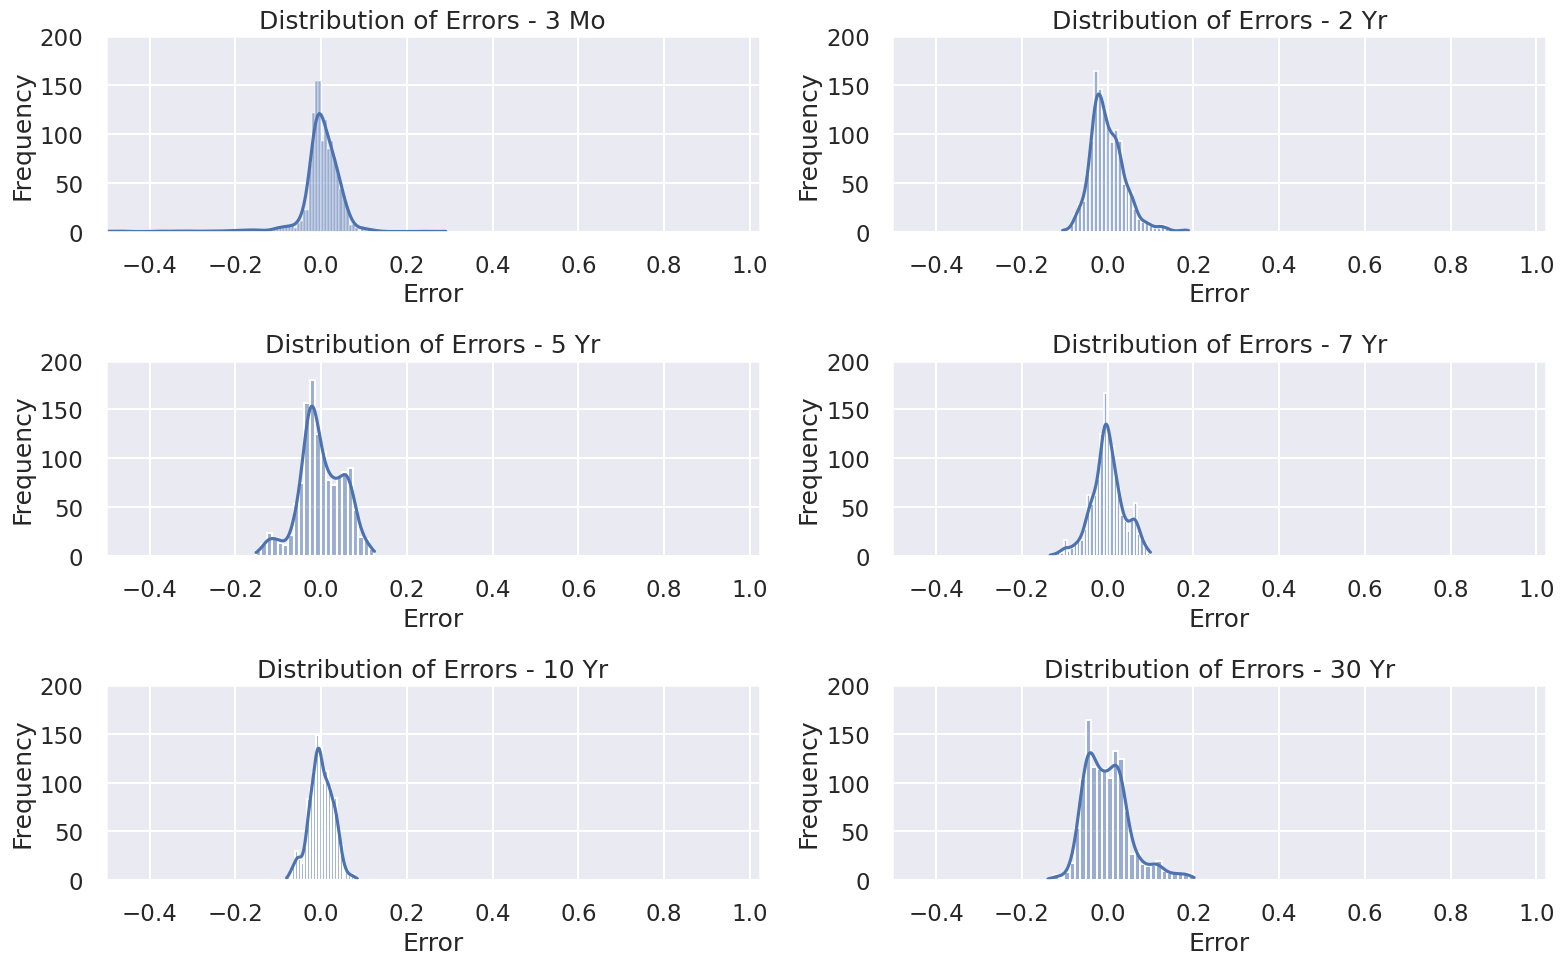

In [36]:
# Set up the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Calculate the common X-axis limits
x_min = df_error.min().min()
x_max = df_error.max().max()
y_min = 0  # Start Y-axis from 0
y_max = 200 # df_error.apply(lambda x: len(x)).max()  # Use the maximum count as Y-axis limit

# Plot the distribution of errors for each column
for i, column in enumerate(["3 Mo", "2 Yr", "5 Yr", "7 Yr", "10 Yr", "30 Yr"]):
    sns.histplot(df_error[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of Errors - {column}')
    axes[i].set_xlabel('Error')
    axes[i].set_ylabel('Frequency')
    
    # Set common X-axis limits
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [37]:
total_return_index = cumulative_return

In [38]:
desc_total_return_index = total_return_index.describe()
desc_total_return_index.loc['count'] = desc_total_return_index.loc['count'].astype(int).astype(str)
desc_total_return_index.iloc[1:] = desc_total_return_index.iloc[1:].applymap('{:.2f}'.format)
desc_total_return_index = desc_total_return_index.loc[['count', 'mean','std']]

desc_total_return_index

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
count,1296,1296,1296,1296,1296,1296,1296,1296,1296,1296,1296,1296
mean,103.62,103.75,103.85,104.18,105.88,108.28,109.67,113.57,117.82,124.49,142.18,167.32
std,2.06,2.08,2.06,1.99,2.55,3.11,3.66,5.53,6.78,9.30,16.29,25.94


In [39]:
cov_total_return_index = total_return_index.cov().applymap('{:.2f}'.format)
print('covariance')
cov_total_return_index.style.background_gradient(cmap='YlGn', axis=1)

covariance


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
1 Mo,4.26,4.29,4.24,3.97,4.49,4.53,3.42,2.75,3.59,4.94,11.05,27.44
2 Mo,4.29,4.33,4.29,4.04,4.62,4.72,3.66,3.13,4.05,5.56,12.15,29.16
3 Mo,4.24,4.29,4.25,4.04,4.68,4.85,3.90,3.55,4.55,6.24,13.27,30.64
6 Mo,3.97,4.04,4.04,3.94,4.82,5.25,4.69,5.02,6.29,8.58,17.02,35.13
1 Yr,4.49,4.62,4.68,4.82,6.48,7.58,7.72,9.63,11.75,15.91,29.40,53.40
2 Yr,4.53,4.72,4.85,5.25,7.58,9.70,10.84,14.66,17.87,24.11,42.78,71.35
3 Yr,3.42,3.66,3.90,4.69,7.72,10.84,13.43,19.67,23.87,32.17,55.27,84.82
5 Yr,2.75,3.13,3.55,5.02,9.63,14.66,19.67,30.59,37.20,50.35,85.08,123.13
7 Yr,3.59,4.05,4.55,6.29,11.75,17.87,23.87,37.20,45.99,62.83,107.67,158.25
10 Yr,4.94,5.56,6.24,8.58,15.91,24.11,32.17,50.35,62.83,86.45,149.51,221.36


In [40]:
corr_total_return_index = total_return_index.corr()
print('correlation')
corr_total_return_index.style.background_gradient(cmap='YlGn', axis=None).format("{:.0%}")

correlation


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
1 Mo,100%,100%,100%,97%,85%,71%,45%,24%,26%,26%,33%,51%
2 Mo,100%,100%,100%,98%,87%,73%,48%,27%,29%,29%,36%,54%
3 Mo,100%,100%,100%,99%,89%,76%,52%,31%,33%,33%,40%,57%
6 Mo,97%,98%,99%,100%,95%,85%,64%,46%,47%,46%,53%,68%
1 Yr,85%,87%,89%,95%,100%,96%,83%,68%,68%,67%,71%,81%
2 Yr,71%,73%,76%,85%,96%,100%,95%,85%,85%,83%,84%,88%
3 Yr,45%,48%,52%,64%,83%,95%,100%,97%,96%,94%,93%,89%
5 Yr,24%,27%,31%,46%,68%,85%,97%,100%,99%,98%,94%,86%
7 Yr,26%,29%,33%,47%,68%,85%,96%,99%,100%,100%,97%,90%
10 Yr,26%,29%,33%,46%,67%,83%,94%,98%,100%,100%,99%,92%


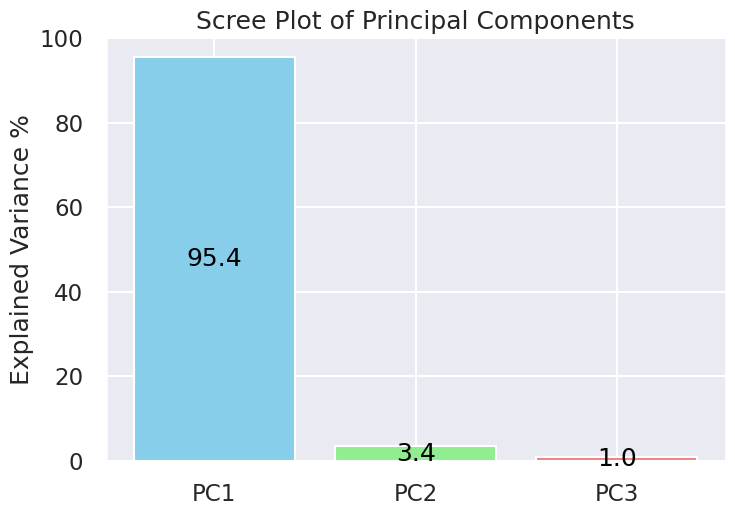

In [41]:
df = total_return_index[tenors["tenor"]]
df.dropna(inplace=True)

instruments = df.columns

scaler = StandardScaler(with_mean=True, with_std=False)
normalized_data = scaler.fit_transform(df)

n_comps = 3
pca = PCA(n_components = n_comps)
principal_components = pca.fit_transform(normalized_data)

per_var = np.round(pca.explained_variance_ratio_ * 100 , decimals=1)

# Assuming 'per_var' is a list containing the explained variance for each PC
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

# Create a bar plot
fig, ax = plt.subplots()
bars = plt.bar(labels, per_var, color=['skyblue', 'lightgreen', 'lightcoral'])

# Add text labels to each bar
for bar, var_ratio in zip(bars, per_var):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{var_ratio:.1f}', 
            ha='center', va='center', color='black')

plt.ylabel('Explained Variance %')
plt.title('Scree Plot of Principal Components')
plt.show()

In [42]:
topPorfolios = pd.DataFrame(pca.components_[:n_comps-1],columns=instruments)
eigenPortfolios = topPorfolios.div(topPorfolios.sum(1),axis=0)
eigenPortfolios.index = ['Duration', 'Convexity']
eigenPortfolios

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Duration,0.012434,0.013341,0.014182,0.016854,0.026845,0.037059,0.045524,0.067590,0.085949,0.119528,0.215606,0.345089
Convexity,2.719846,2.700962,2.605010,2.175179,1.745945,0.799829,-0.983252,-3.471061,-3.704265,-4.637922,-4.401307,5.451038


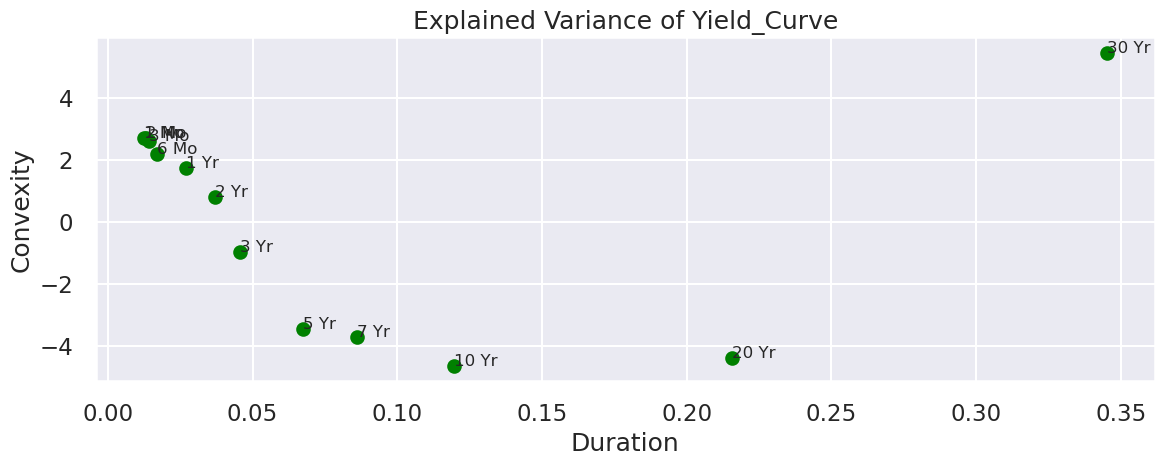

In [43]:
plt.figure(figsize=(12, 5))  # Set the overall figure size

# PC1 vs. PC2 subplot
# plt.subplot(1, 3, 1)
plt.scatter(eigenPortfolios.loc['Duration'], eigenPortfolios.loc['Convexity'], color='green')
plt.title('Explained Variance of Yield_Curve')
for i, label in enumerate(tenors["tenor"]):
    plt.annotate(label, (eigenPortfolios.loc['Duration'][i], eigenPortfolios.loc['Convexity'][i]), size=12)
plt.xlabel('Duration')
plt.ylabel('Convexity')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

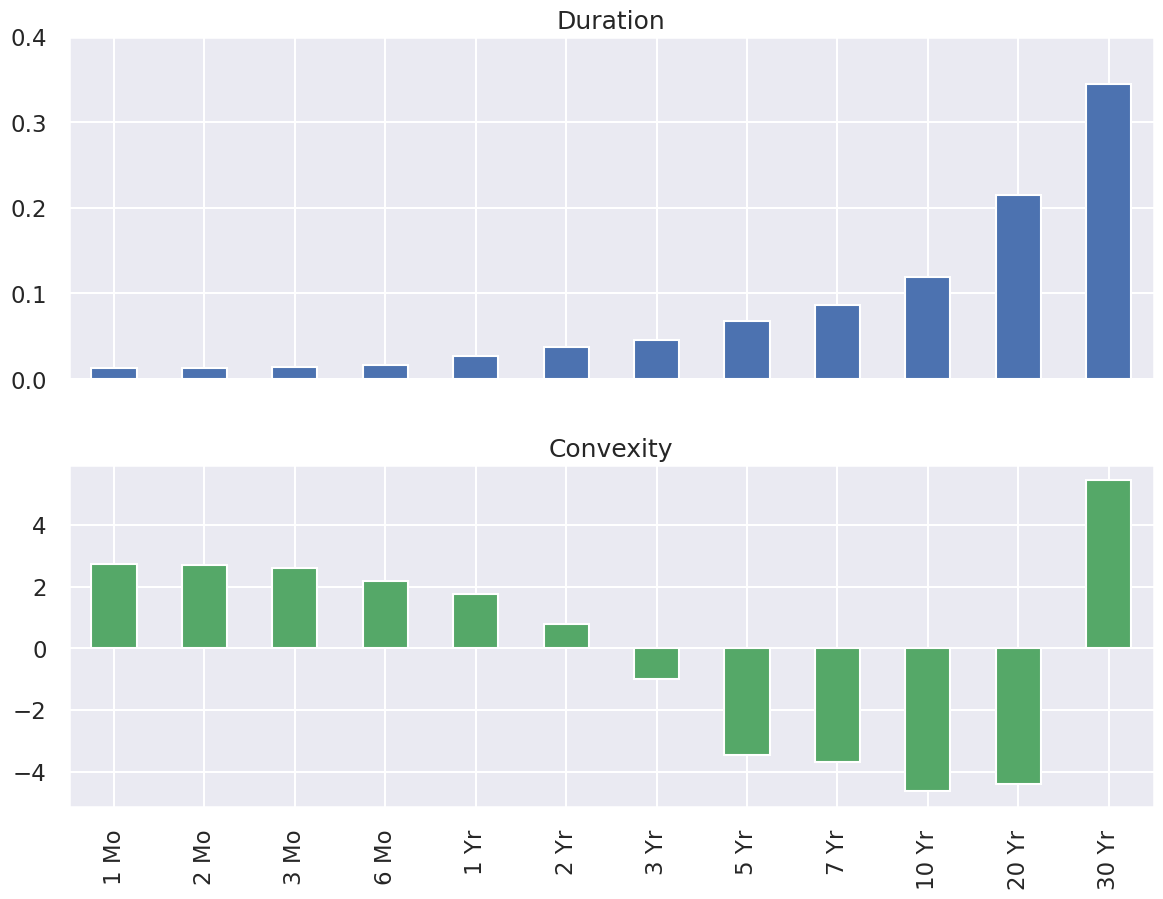

In [44]:
axs = eigenPortfolios.T.plot.bar(subplots=True,figsize=(14,10),legend=False)
plt.subplots_adjust(hspace=0.25)
axs[0].set_ylim(0,.4);

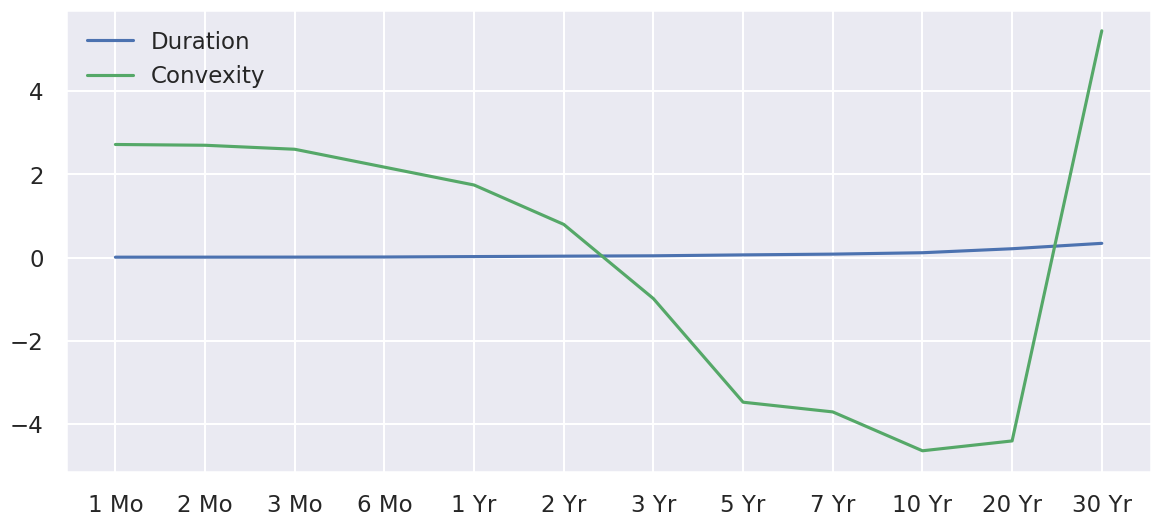

In [45]:
axs = eigenPortfolios.T.plot(subplots=False,figsize=(14,6),legend=True);
axs.set_xticks(range(len(instruments)))
axs.set_xticklabels(instruments);